# Análise da Eficácia e Generalização de Modelo de Regressão para Diferentes Tamanhos de Fibra Óptica

In [1]:
import numpy as np
from optic.torchUtils import slidingWindowDataSet, MLP
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.dsp.core import pulseShape, lowPassFIR, pnorm, signal_power
from optic.utils import parameters, dBm2W
from optic.models.devices import mzm, photodiode, edfa
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray

from tqdm.notebook import tqdm
from commpy.utilities  import upsample
from optic.dsp.core import firFilter
from optic.models.channels import linearFiberChannel
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import OpticFunctions as of
import importlib
import IPython.display as ipd

In [3]:
importlib.reload(of)

<module 'OpticFunctions' from 'C:\\Users\\jezra\\Redes Neurais - Pytorch\\OpticFunctions.py'>

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

figsize(10, 3)

In [5]:
# %load_ext autoreload
# %autoreload 2

In [6]:
np.random.seed(seed=123)

## Fibra com 60 km

In [7]:
SpS = 16  # Amostras por símbolo
Mod_ord = 4              # Ordem do formato de modulação
Sr = 10e9          # taxa de símbolos

#Simulação do Sinal
sinalt_60, symbt_60 = of.SimulaSinalOptico(SpS = SpS, M = Mod_ord, Rs = Sr)

In [8]:
#Parâmetros do Canal
fibra_60 = 60
ruido = 4.5

sinalr_60 = of.SimulaCanalOptico(sinal = sinalt_60, Rs = Sr, SpS = SpS,  dist_fibra = fibra_60, ruido = ruido)

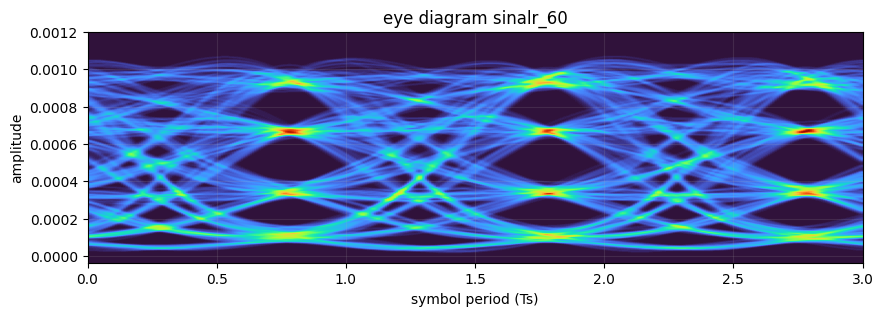

In [9]:
of.PlotEyediagram(sinalr_60, SpS, label = 'sinalr_60')

## Fibra com 80 km

In [10]:
sinalt_80, symbt_80 = of.SimulaSinalOptico(SpS = SpS, M = Mod_ord, Rs = Sr)

In [11]:
fibra_80 = 80

sinalr_80 = of.SimulaCanalOptico(sinal = sinalt_80, Rs = Sr, SpS = SpS, dist_fibra = fibra_80, ruido = ruido)

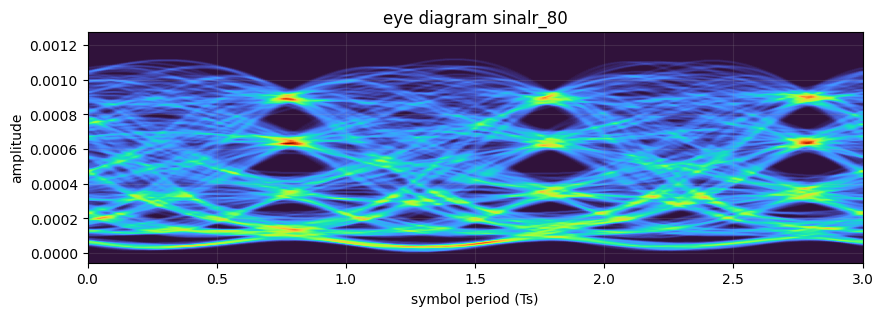

In [12]:
of.PlotEyediagram(sinalr_80, SpS, label = 'sinalr_80')

## Fibra com 100 km

In [13]:
sinalt_100, symbt_100 = of.SimulaSinalOptico(SpS = SpS, M = Mod_ord, Rs = Sr)

In [14]:
fibra_100 = 100

sinalr_100 = of.SimulaCanalOptico(sinal = sinalt_100, Rs = Sr, SpS = SpS, dist_fibra = fibra_100, ruido = ruido)

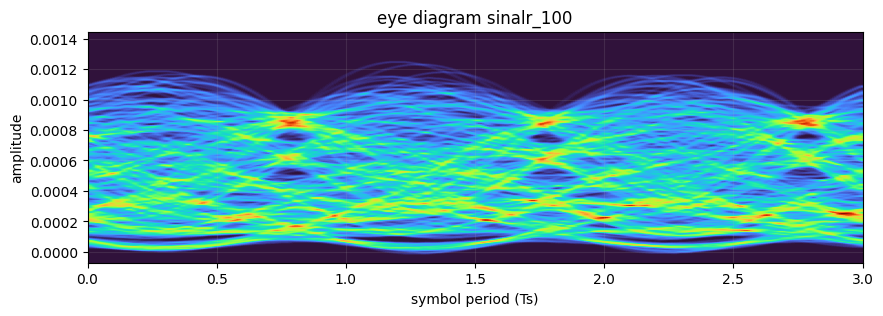

In [15]:
of.PlotEyediagram(sinalr_100, SpS, label = 'sinalr_100')

## Criação dos Conjuntos de Dados

Aqui o conjunto de dados para treinamento será composto por 80% dos sinais que foram transmitidos pelas fibras, e o conjunto de avaliação dos outros 20% de cada sinal.

Para avaliação do modelo em seguida, há trêns conjuntos de dados, cada um contendo um sinal isolado de um dos três canais 

In [16]:
from torch.utils.data import ConcatDataset

In [17]:
SpS_in = 16
Ntaps = 64
batch_size = 64
shuffle = True
shuffle_full = False

train_dataset_60, test_dataset_60, full_dataset_60 = of.CriaDataSet(symb = symbt_60, signal = sinalr_60, SpS_in = SpS_in)
train_dataset_80, test_dataset_80, full_dataset_80 = of.CriaDataSet(symb = symbt_80, signal = sinalr_80, SpS_in = SpS_in)
train_dataset_100, test_dataset_100, full_dataset_100 = of.CriaDataSet(symb = symbt_100, signal = sinalr_100, SpS_in = SpS_in)

comb_train_ds = ConcatDataset([train_dataset_60, train_dataset_80, train_dataset_100])
comb_test_ds = ConcatDataset([test_dataset_60, test_dataset_80, test_dataset_100])

train_dataloader = DataLoader(comb_train_ds, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(comb_test_ds, batch_size=batch_size, shuffle=shuffle)

full_dataloader_60 = DataLoader(full_dataset_60, batch_size=batch_size, shuffle=shuffle_full)
full_dataloader_80 = DataLoader(full_dataset_80, batch_size = batch_size, shuffle = shuffle_full)
full_dataloader_100 = DataLoader(full_dataset_100, batch_size = batch_size, shuffle = shuffle_full)

## Criação do modelo

Aqui será definido um modelo de rede neural MLP, com 5 camadas lineares, e utilizando a função ReLU como camada oculta. Esse modelo tem uma complexidade moderada, mas apropriada para o tamanho dos conjuntos de dados utilizados


In [18]:
modelo = MLP([Ntaps, 50, 32, 16, 8, 4, 1])

### Definição dos Hiperparâmetros

In [19]:
loss = nn.MSELoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr = 0.00011)
epochs = 10
cada_print = 5000

In [20]:
framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)

In [21]:
for t in range(epochs):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader, modelo, loss, optimizer, cada_print)
    of.test_loop(test_dataloader, modelo, loss)
print("Pronto!")
framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)

Época 1
-------------------------------
loss: 1.156746[   64/2400000]
loss: 0.007026[320064/2400000]
loss: 0.006155[640064/2400000]
loss: 0.008448[960064/2400000]
loss: 0.004802[1280064/2400000]
loss: 0.002565[1600064/2400000]
loss: 0.002552[1920064/2400000]
loss: 0.001479[2240064/2400000]
Perda média: 0.001362 

Época 2
-------------------------------
loss: 0.000953[   64/2400000]
loss: 0.000373[320064/2400000]
loss: 0.000571[640064/2400000]
loss: 0.000283[960064/2400000]
loss: 0.000091[1280064/2400000]
loss: 0.002125[1600064/2400000]
loss: 0.000032[1920064/2400000]
loss: 0.000040[2240064/2400000]
Perda média: 0.000047 

Época 3
-------------------------------
loss: 0.000021[   64/2400000]
loss: 0.000020[320064/2400000]
loss: 0.000044[640064/2400000]
loss: 0.000055[960064/2400000]
loss: 0.000203[1280064/2400000]
loss: 0.000009[1600064/2400000]
loss: 0.000018[1920064/2400000]
loss: 0.000005[2240064/2400000]
Perda média: 0.000046 

Época 4
-------------------------------
loss: 0.000022[

In [22]:
of.test_loop(full_dataloader_60, modelo, loss)
of.test_loop(full_dataloader_80, modelo, loss)
of.test_loop(full_dataloader_100, modelo, loss)

Perda média: 0.000003 

Perda média: 0.000002 

Perda média: 0.000073 



### Observações
Como não se pode analisar a eficácia do equalizador somente a partir da função de perda, vamos analisar a BER do sinal sem e com equalizador para a potência de entrada já estabelecida. Após isso, vamos fazer um teste mais rigoroso, para diferentes potências de entrada do sinal, utilizando uma fibra de 70 km.

Number of counted errors = 138 
BER = 6.90e-05 


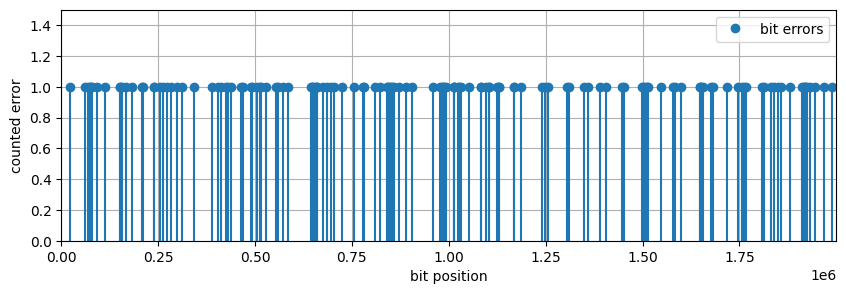

In [23]:
bitsr_80 = of.RecuperaBits(sinal = sinalr_80, SpS = SpS, M = Mod_ord)
bitst_80 = of.RecuperaBits(sinal = sinalt_80, SpS = SpS, M = Mod_ord)
#Calcula a taxa de erro entre os bits

of.CalculaBER(bitst_80, bitsr_80)

Number of counted errors = 0 
BER = 0.00e+00 


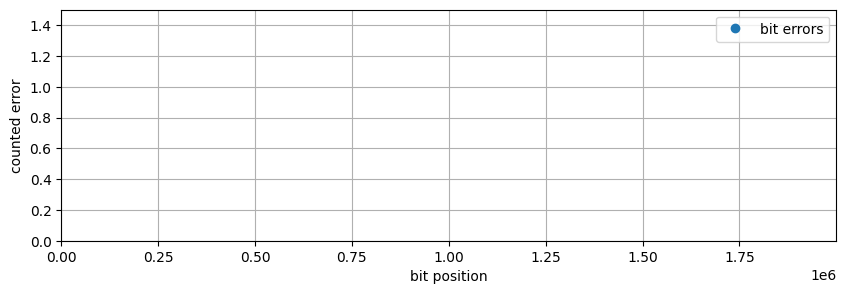

In [24]:
#symb_rx_nn = of.GeraSinalEqualizado(modelo, full_dataloader_60)
modelo.eval()
symbRx_NN_list = []  # inicializa uma lista vazia
with torch.no_grad():
    for batch, (X, y) in enumerate(full_dataloader_80):
        X = X.float()
        pred = modelo(X)

        # adiciona os símbolos preditos à lista
        symbRx_NN_list.append(pred.numpy().reshape(-1,))

# concatena todos os símbolos preditos em um único array NumPy
symbRx_NN = np.concatenate(symbRx_NN_list)
        

const = GrayMapping(Mod_ord, 'pam') 
Es = signal_power(const)
#print(symb_rx_nn.shape)
bits_rx_nn = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), Mod_ord, 'pam')
bitt = demodulateGray(np.sqrt(Es)*pnorm(symbt_80), Mod_ord, 'pam')

of.CalculaBER(bitt, bits_rx_nn)

## Calculando a BER por Potência de Entrada para fibra de 90 km

In [25]:
discard = 100
power = np.arange(-15, 0)
BER = np.zeros(power.size)
BER_NN = np.zeros(power.size)
SpS_out = 1
Ntaps = 64

for ind, Pin in enumerate(power):
    sinaltx90, symbtx90 = of.SimulaSinalOptico(SpS = SpS, Rs = Sr, M = Mod_ord, Pi_dBm = Pin)
    
    irx90 = of.SimulaCanalOptico(sinaltx90, SpS = SpS, Rs = Sr, dist_fibra = 90)
    
    bitsTx90 = of.RecuperaBits(sinaltx90, SpS, Mod_ord)
    bitsRx90 = of.RecuperaBits(irx90, SpS, Mod_ord)
    
    err = np.logical_xor(bitsRx90[discard:bitsRx90.size-discard], bitsTx90[discard:bitsTx90.size-discard])
    BER[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER[ind]))
    
    signalrx = pnorm(irx90[0::SpS//SpS_out])
    signalrx= (signalrx - np.mean(signalrx))/np.std(signalrx)
    
    dataset = slidingWindowDataSet(signalrx, symbtx90, Ntaps, SpS_out)
    
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    modelo.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.float()
            pred = modelo(X)
            symbRx_NN = pred
            symbRx_NN = symbRx_NN.numpy().reshape(-1,)
    
    bitsRx_NN = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), Mod_ord, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRx_NN[discard:bitsRx_NN.size-discard], bitsTx90[discard:bitsTx90.size-discard])
    BER_NN[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN[ind]))

framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)

BER = 1.10e-01 
BER_NN = 1.01e-01 
BER = 8.69e-02 
BER_NN = 7.44e-02 
BER = 6.73e-02 
BER_NN = 5.21e-02 
BER = 5.12e-02 
BER_NN = 3.50e-02 
BER = 3.82e-02 
BER_NN = 2.21e-02 
BER = 2.81e-02 
BER_NN = 1.31e-02 
BER = 2.04e-02 
BER_NN = 7.23e-03 
BER = 1.50e-02 
BER_NN = 3.86e-03 
BER = 1.11e-02 
BER_NN = 1.78e-03 
BER = 8.51e-03 
BER_NN = 7.93e-04 
BER = 6.65e-03 
BER_NN = 3.11e-04 
BER = 5.33e-03 
BER_NN = 1.20e-04 
BER = 4.55e-03 
BER_NN = 3.60e-05 
BER = 4.00e-03 
BER_NN = 9.50e-06 
BER = 3.50e-03 
BER_NN = 2.50e-06 


Text(0, 0.5, 'log10(BER)')

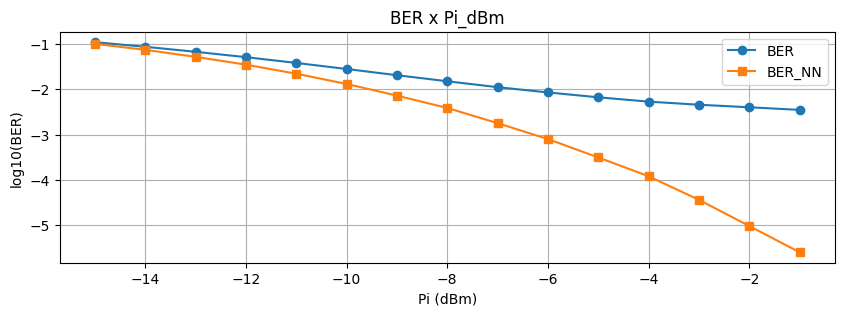

In [26]:
plt.plot(power, np.log10(BER),'-o', label='BER')
plt.plot(power, np.log10(BER_NN),'-s', label='BER_NN')
plt.grid()
plt.legend();
plt.title('BER x Pi_dBm')
plt.xlabel('Pi (dBm)')
plt.ylabel('log10(BER)')

# Fibra com 70 km

In [42]:
discard = 100
power = np.arange(-15, -4)
BER = np.zeros(power.size)
BER_NN = np.zeros(power.size)
SpS_out = 1
Ntaps = 64

for ind, Pin in enumerate(power):
    sinaltx90, symbtx90 = of.SimulaSinalOptico(SpS = SpS, Rs = Sr, M = Mod_ord, Pi_dBm = Pin)
    
    irx90 = of.SimulaCanalOptico(sinaltx90, SpS = SpS, Rs = Sr, dist_fibra = 70)
    
    bitsTx90 = of.RecuperaBits(sinaltx90, SpS, Mod_ord)
    bitsRx90 = of.RecuperaBits(irx90, SpS, Mod_ord)
    
    err = np.logical_xor(bitsRx90[discard:bitsRx90.size-discard], bitsTx90[discard:bitsTx90.size-discard])
    BER[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER[ind]))
    
    signalrx = pnorm(irx90[0::SpS//SpS_out])
    signalrx= (signalrx - np.mean(signalrx))/np.std(signalrx)
    
    dataset = slidingWindowDataSet(signalrx, symbtx90, Ntaps, SpS_out)
    
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    modelo.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.float()
            pred = modelo(X)
            symbRx_NN = pred
            symbRx_NN = symbRx_NN.numpy().reshape(-1,)
    
    bitsRx_NN = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), Mod_ord, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRx_NN[discard:bitsRx_NN.size-discard], bitsTx90[discard:bitsTx90.size-discard])
    BER_NN[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN[ind]))

BER = 4.36e-02 
BER_NN = 4.74e-02 
BER = 2.54e-02 
BER_NN = 2.94e-02 
BER = 1.36e-02 
BER_NN = 1.72e-02 
BER = 6.44e-03 
BER_NN = 9.23e-03 
BER = 2.84e-03 
BER_NN = 5.12e-03 
BER = 1.08e-03 
BER_NN = 2.53e-03 
BER = 3.73e-04 
BER_NN = 1.16e-03 
BER = 1.07e-04 
BER_NN = 5.30e-04 
BER = 2.75e-05 
BER_NN = 2.36e-04 
BER = 8.50e-06 
BER_NN = 9.75e-05 
BER = 5.00e-07 
BER_NN = 3.65e-05 


Text(0, 0.5, 'log10(BER)')

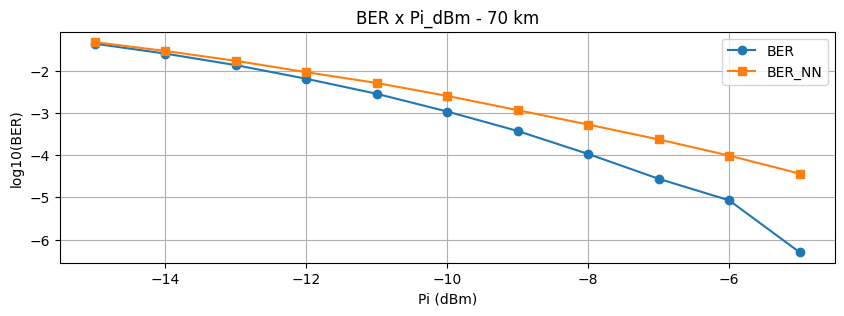

In [43]:
plt.plot(power, np.log10(BER),'-o', label='BER')
plt.plot(power, np.log10(BER_NN),'-s', label='BER_NN')
plt.grid()
plt.legend();
plt.title('BER x Pi_dBm - 70 km')
plt.xlabel('Pi (dBm)')
plt.ylabel('log10(BER)')

# Fibra com 110 km

In [38]:
discard = 100
power = np.arange(-15, 0)
BER = np.zeros(power.size)
BER_NN = np.zeros(power.size)
SpS_out = 1
Ntaps = 64

for ind, Pin in enumerate(power):
    sinaltx90, symbtx90 = of.SimulaSinalOptico(SpS = SpS, Rs = Sr, M = Mod_ord, Pi_dBm = Pin)
    
    irx90 = of.SimulaCanalOptico(sinaltx90, SpS = SpS, Rs = Sr, dist_fibra = 120)
    
    bitsTx90 = of.RecuperaBits(sinaltx90, SpS, Mod_ord)
    bitsRx90 = of.RecuperaBits(irx90, SpS, Mod_ord)
    
    err = np.logical_xor(bitsRx90[discard:bitsRx90.size-discard], bitsTx90[discard:bitsTx90.size-discard])
    BER[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER[ind]))
    
    signalrx = pnorm(irx90[0::SpS//SpS_out])
    signalrx= (signalrx - np.mean(signalrx))/np.std(signalrx)
    
    dataset = slidingWindowDataSet(signalrx, symbtx90, Ntaps, SpS_out)
    
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    modelo.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.float()
            pred = modelo(X)
            symbRx_NN = pred
            symbRx_NN = symbRx_NN.numpy().reshape(-1,)
    
    bitsRx_NN = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), Mod_ord, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRx_NN[discard:bitsRx_NN.size-discard], bitsTx90[discard:bitsTx90.size-discard])
    BER_NN[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN[ind]))

BER = 2.66e-01 
BER_NN = 2.66e-01 
BER = 2.41e-01 
BER_NN = 2.39e-01 
BER = 2.19e-01 
BER_NN = 2.12e-01 
BER = 1.99e-01 
BER_NN = 1.88e-01 
BER = 1.81e-01 
BER_NN = 1.64e-01 
BER = 1.66e-01 
BER_NN = 1.44e-01 
BER = 1.53e-01 
BER_NN = 1.25e-01 
BER = 1.40e-01 
BER_NN = 1.07e-01 
BER = 1.30e-01 
BER_NN = 9.13e-02 
BER = 1.21e-01 
BER_NN = 7.73e-02 
BER = 1.13e-01 
BER_NN = 6.50e-02 
BER = 1.07e-01 
BER_NN = 5.51e-02 
BER = 1.02e-01 
BER_NN = 4.68e-02 
BER = 9.71e-02 
BER_NN = 3.95e-02 
BER = 9.33e-02 
BER_NN = 3.38e-02 


Text(0, 0.5, 'log10(BER)')

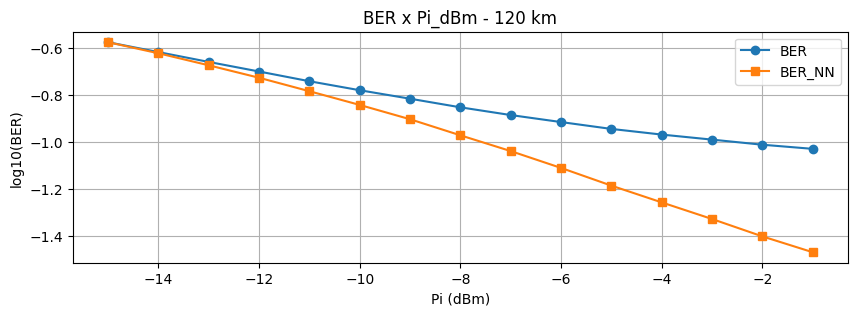

In [40]:
plt.plot(power, np.log10(BER),'-o', label='BER')
plt.plot(power, np.log10(BER_NN),'-s', label='BER_NN')
plt.grid()
plt.legend();
plt.title('BER x Pi_dBm - 120 km')
plt.xlabel('Pi (dBm)')
plt.ylabel('log10(BER)')

In [31]:
discard = 100
power = np.arange(-15, 0)
BER = np.zeros(power.size)
BER_NN = np.zeros(power.size)
SpS_out = 1
Ntaps = 64

for ind, Pin in enumerate(power):
    sinaltx90, symbtx90 = of.SimulaSinalOptico(SpS = SpS, Rs = Sr, M = Mod_ord, Pi_dBm = Pin)
    
    irx90 = of.SimulaCanalOptico(sinaltx90, SpS = SpS, Rs = Sr, dist_fibra = 80)
    
    bitsTx90 = of.RecuperaBits(sinaltx90, SpS, Mod_ord)
    bitsRx90 = of.RecuperaBits(irx90, SpS, Mod_ord)
    
    err = np.logical_xor(bitsRx90[discard:bitsRx90.size-discard], bitsTx90[discard:bitsTx90.size-discard])
    BER[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER[ind]))
    
    signalrx = pnorm(irx90[0::SpS//SpS_out])
    signalrx= (signalrx - np.mean(signalrx))/np.std(signalrx)
    
    dataset = slidingWindowDataSet(signalrx, symbtx90, Ntaps, SpS_out)
    
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    modelo.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.float()
            pred = modelo(X)
            symbRx_NN = pred
            symbRx_NN = symbRx_NN.numpy().reshape(-1,)
    
    bitsRx_NN = demodulateGray(np.sqrt(Es)*pnorm(symbRx_NN), Mod_ord, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRx_NN[discard:bitsRx_NN.size-discard], bitsTx90[discard:bitsTx90.size-discard])
    BER_NN[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN[ind]))

BER = 7.15e-02 
BER_NN = 6.76e-02 
BER = 5.00e-02 
BER_NN = 4.51e-02 
BER = 3.31e-02 
BER_NN = 2.82e-02 
BER = 2.13e-02 
BER_NN = 1.69e-02 
BER = 1.29e-02 
BER_NN = 9.41e-03 
BER = 7.62e-03 
BER_NN = 4.97e-03 
BER = 4.25e-03 
BER_NN = 2.53e-03 
BER = 2.46e-03 
BER_NN = 1.17e-03 
BER = 1.40e-03 
BER_NN = 4.98e-04 
BER = 7.91e-04 
BER_NN = 2.11e-04 
BER = 5.35e-04 
BER_NN = 7.30e-05 
BER = 3.62e-04 
BER_NN = 2.35e-05 
BER = 2.34e-04 
BER_NN = 8.00e-06 
BER = 1.34e-04 
BER_NN = 2.50e-06 
BER = 1.13e-04 
BER_NN = 5.00e-07 


Text(0, 0.5, 'log10(BER)')

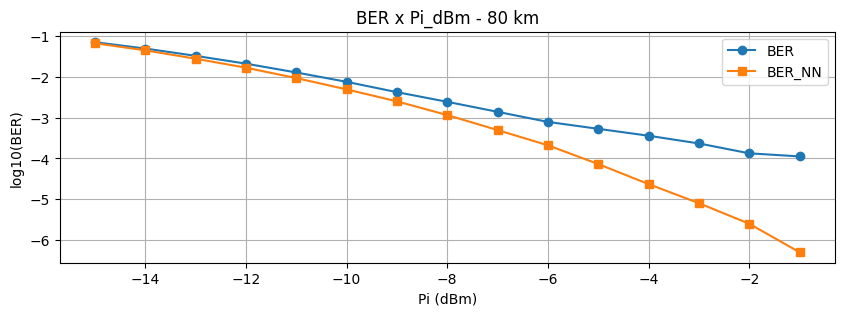

In [32]:
plt.plot(power, np.log10(BER),'-o', label='BER')
plt.plot(power, np.log10(BER_NN),'-s', label='BER_NN')
plt.grid()
plt.legend();
plt.title('BER x Pi_dBm - 80 km')
plt.xlabel('Pi (dBm)')
plt.ylabel('log10(BER)')

In [33]:
# simulation parameters
SpS = 16            # Samples per symbol
M = 4               # order of the modulation format
Rs = 40e9           # Symbol rate (for the OOK case, Rs = Rb)
Fs = SpS*Rs         # Signal sampling frequency (samples/second)
Ts = 1/Fs           # Sampling period

# Laser power
Pi_dBm = 0         # laser optical power at the input of the MZM in dBm
Pi = dBm2W(Pi_dBm) # convert from dBm to W

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# fiber channel parameters
distance = np.arange(50,125,5) # transmission distance in km
paramCh = parameters()
paramCh.α = 0.2        # fiber loss parameter [dB/km]
paramCh.D = 16         # fiber dispersion parameter [ps/nm/km]
paramCh.Fc = 193.1e12  # central optical frequency [Hz]
paramCh.Fs = Fs        # simulation sampling frequency [samples/second]

# receiver pre-amplifier parameters
paramEDFA = parameters()
paramEDFA.NF = 4.5   # edfa noise figure 
paramEDFA.Fc = paramCh.Fc
paramEDFA.Fs = Fs


# photodiode parameters
paramPD = parameters()
paramPD.ideal = False
paramPD.B = Rs
paramPD.Fs = Fs

BER = np.zeros(distance.shape)
Pb = np.zeros(distance.shape)

const = GrayMapping(M,'pam') # get PAM constellation
Es = signal_power(const) # calculate the average energy per symbol of the PAM constellation
    
discard = 100
for indL, L in enumerate(tqdm(distance)):
        
    # generate pseudo-random bit sequence
    bitsTx = np.random.randint(2, size=int(np.log2(M)*1e5))
    n = np.arange(0, bitsTx.size)

    # generate ook modulated symbol sequence
    symbTx = modulateGray(bitsTx, M, 'pam')    
    symbTx = pnorm(symbTx) # power normalization

    # upsampling
    symbolsUp = upsample(symbTx, SpS)

    # pulse formatting
    sigTx = firFilter(pulse, symbolsUp)

    # optical modulation
    Ai = np.sqrt(Pi)*np.ones(sigTx.size)
    sigTxo = mzm(Ai, 0.25*sigTx, paramMZM)
    
    # linear optical channel   
    paramCh.L = L
    sigCh = linearFiberChannel(sigTxo, paramCh)

    # receiver pre-amplifier
    if L > 0:
        paramEDFA.G = paramCh.α*L  # edfa gain       
        sigCh = edfa(sigCh, paramEDFA)

    # pin receiver
    I_Rx = photodiode(sigCh, paramPD)
    I_Rx = I_Rx/np.std(I_Rx)

    # capture samples in the middle of signaling intervals
    symbRx = I_Rx[0::SpS]

    # subtract DC level and normalize power
    symbRx = symbRx - symbRx.mean()
    symbRx = pnorm(symbRx)
    
    snr = signal_power(symbRx)/(2*signal_power(symbRx-symbTx))
    EbN0 = 10*np.log10(snr/np.log2(M))
    
    # demodulate symbols to bits with minimum Euclidean distance 
    bitsRx = demodulateGray(np.sqrt(Es)*symbRx, M, 'pam')

    err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
    BER[indL] = np.mean(err)

  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\jezra\AppData\Local\Temp\ipykernel_19140\2614596433.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(distance, np.log10(Pb),'--',label='Pb (theory)')


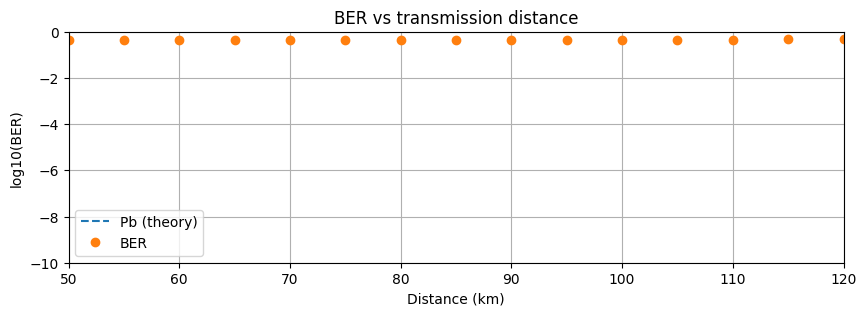

In [34]:
plt.figure()
plt.plot(distance, np.log10(Pb),'--',label='Pb (theory)')
plt.plot(distance, np.log10(BER),'o',label='BER')
plt.grid()
plt.ylabel('log10(BER)')
plt.xlabel('Distance (km)');
plt.title('BER vs transmission distance')
plt.legend();
plt.ylim(-10,0);
plt.xlim(min(distance), max(distance));

In [41]:
/help(LinearFiberChannel)

NameError: name 'LinearFiberChannel' is not defined